In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.extmath import safe_sparse_dot

from matchers import metrics
from matchers import utils
from matchers import dataset

In [16]:
np.set_printoptions(suppress=True)
tqdm.pandas()

### Load and process data

In [17]:
input_names, weighted_relevant_names, all_candidates = dataset.load_preprocess()
relevant_names = [[name for name,weight in name_weights] for name_weights in weighted_relevant_names]

### Model

In [18]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char_wb', min_df=10, max_df=0.5)

In [19]:
X = vectorizer.fit_transform(all_candidates)

#### Similarity Function

In [20]:
def get_similars(name, k=10, demo_mode=False):
    if demo_mode:
        name = utils.add_padding(name)
    x = vectorizer.transform([name]).toarray()
    scores = safe_sparse_dot(X, x.T).flatten()
    sorted_scores_idx = np.argsort(scores)[::-1][:k]
    candidates = all_candidates[sorted_scores_idx]
    if demo_mode:
        candidates = [utils.remove_padding(candidate) for candidate in candidates]
    candidates_scores = scores[sorted_scores_idx]
    
    return list(zip(candidates, candidates_scores))

#### Demo

In [21]:
get_similars('schumacher', 10, True)

[('schumacker', 0.8092917375133883),
 ('schuman', 0.7500946651703772),
 ('schumann', 0.7027601314426228),
 ('schumaker', 0.6902077476321085),
 ('schacher', 0.6547967092097396),
 ('schum', 0.6372697150535586),
 ('scheuman', 0.5581147793510491),
 ('hamacher', 0.5418542569428892),
 ('amacher', 0.5358002092434179),
 ('stelmacher', 0.5294070446892176)]

### Generate candidates for all names

In [22]:
k = 100 # Number of candidates
name_candidates = list(map(lambda x: get_similars(x, k=k), tqdm(input_names)))
candidates = np.array(name_candidates)[:, :, 0]

100%|██████████| 23587/23587 [00:57<00:00, 410.28it/s]


### Evaluation

### mAP@1

In [23]:
metrics.mean_avg_precision_k(relevant_names, candidates, 1)

0.4927714418959596

### mAP@3

In [24]:
metrics.mean_avg_precision_k(relevant_names, candidates, 3)

0.4073265405143134

### Precision-Recall Curve

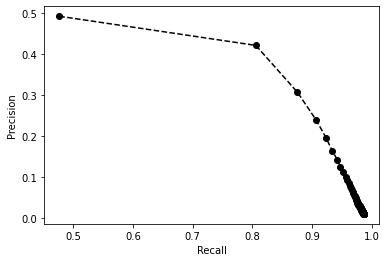

In [28]:
# Number of rank cutoffs to test i.e precision_{i}, recall_{i} for i in (1, ..., N)
N = 100
metrics.precision_recall_curve(relevant_names, candidates, N)